## Работа с текстовыми данными

В остальной части задания мы будем работать с вопросами заданными на [Stack Overflow](https://stackoverflow.com/) в 2019 году.

Задача состоит в том, что бы по вопросу определить его тэг. Вообще, у вопроса может быть несколько тэгов (так будет в соревновании), но сейчас мы упростим задачу - будем отличать вопросы о `python` от всех остальных.

Загрузите данные для обучения из [третьего конкурса](https://www.kaggle.com/c/competition-3-yandex-shad-spring-2020) и сформируйте новые бинарные метки классов: "о python" и "не о python".

Изменим ответы таким образом, что 1 будет, если класс содержит тег python, 0 - иначе

In [32]:
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
random_state=42
%matplotlib inline

In [2]:
X_train_initial = pd.read_csv('../data3/X_train.csv').set_index('id')
X_train_initial[['title']].to_csv('../data3/X_train_cut.csv')

In [3]:
X_train_initial = pd.read_csv('../data3/X_train_cut.csv').set_index('id')
y_train_initial = pd.read_csv('../data3/y_train.csv').set_index('id')

In [4]:
y_train_p = y_train_initial.copy()
y_train_p['name'] = y_train_initial['name'].str.contains(r'\bpython\b').astype(int)

In [5]:
y_train_p.head()

name
id            
56685310     0
55893408     0
55807871     0
54842410     0
55572776     1

Для оценивания качества в данной задаче используйте отложенную выборку -- разделите данные на train и test (тестовых данных должно быть 30%)

При разбиении выборки на две части, необходимо будет учесть следующие особенности разбиения:
 - разбиение должно быть воспроизводимо;
 - соотношение классов в каждой из частей должно сохраняться.

Для воспроизводимости зафиксируем random_state.

Проверим соотношение классов после разбиения. mean должно совпадать.

In [6]:
X_train, X_test, y_train_pre, y_test_pre = train_test_split(X_train_initial, y_train_p, test_size=0.3, random_state=random_state)
y_train = np.array(y_train_pre).ravel()
y_test = np.array(y_test_pre).ravel()

In [7]:
y_train_pre.describe()

name
count  825281.000000
mean        0.174943
std         0.379918
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

In [8]:
y_test_pre.describe()

name
count  353692.000000
mean        0.174847
std         0.379837
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

Одна из сложностей данной задачи — текстовое представление данных, так как не существует какого-то универсального способа извлечения признаков из текстов. По ходу работы мы получим несколько наборов признаков, которые будем сравнивать между собой.

### Задание

**(2 балла)**

Попробуйте самый простой подход, а именно [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) кодирование данных. С помощью него каждый текст будет представлен в виде вектора, размер которого равен размеру словаря, а на каждой позиции стоит число, сколько раз соответствующее слово встретилось в этом тексте. Для данного подхода хорошей практикой является фильтрация стоп-слов.

Такое представление можно получить используя класс [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) из библиотеки sklearn. Одно из удобств данного метода состоит в том, что возвращаемый результат является [sparse](http://docs.scipy.org/doc/scipy-0.15.1/reference/sparse.html)-матрицей, так как при таком преобразовании получается достаточно много нулей. Более подробно про такие матрицы было рассказано на [семинаре](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/xswzs2g414wggh9/seminar_8.ipynb), также про это можно прочитать, например, [здесь](http://www.scipy-lectures.org/advanced/scipy_sparse/index.html).

* Примените *bag-of-words* кодирование для заголовков (title) вопросов. Обучать преобразование следует на обучающей выборке, после чего применять его к тестовой. Какой размерности стали данные? Возможно ли сократить размерность векторного представления изменяя параметры *CountVectorizer* без существенной потери информативности? Поясните как именно;
* Обучите логистическую регрессию и случайный лес (параметры моделей подберите самостоятельно, используя понравившийся вам метод поиска гиперпараметров) на *bag-of-words* представлении выборки и измерьте качество на тестовых данных с помощью трех описанных выше метрик: *Accuracy*, *Precision*, *Recall*. Кроме того, сравните *время* обучения алгоритмов;
* Есть ли существенная разница в качестве предсказаний данных алгоритмов? Какой из методов кажется менее применимым в данной задаче и почему?
* Есть ли разница в качестве классификации между классами? С каким классом модель справляется лучше? С чем это может быть связанно?

Замечание: Если модели обучаются слишком долго на всём корпусе, то можно взять его подмножество и выполнять задания лабораторной работы на нём (постарайтесь не брать слишком маленькую подвыборку)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(list(X_train['title']))
X_test_vec = vectorizer.transform(X_test['title'])

In [12]:
X_test_vec

<353692x128223 sparse matrix of type '<class 'numpy.int64'>'
	with 3207545 stored elements in Compressed Sparse Row format>

Получили 128 223 новых признаков.

Для уменьшения размерности уберем слова, которые встречаются менее трёх раз.
Это позволяет почти в 4 раза сократить количество признаков, при этом на наших объемах данных это не сильно скажется на качестве.

In [13]:
X_train_c = X_train[['title']].copy()
vectorizer = CountVectorizer(stop_words='english', min_df=3)
vectorizer.fit(list(X_train_c['title']))
X_test_vec = vectorizer.transform(X_test['title'])

In [14]:
X_test_vec

<353692x35125 sparse matrix of type '<class 'numpy.int64'>'
	with 2054292 stored elements in Compressed Sparse Row format>

### Подготовим обучающую выборку

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

n = 10000

vectorizer = CountVectorizer(stop_words='english', min_df=3)
X_train_vec = vectorizer.fit_transform(list(X_train['title'][:n]))
X_test_vec = vectorizer.transform(X_test['title'])
y_train_vec = y_train[:n]
X_train_vec

<10000x2890 sparse matrix of type '<class 'numpy.int64'>'
	with 51606 stored elements in Compressed Sparse Row format>

Подберём оптимальные параметры для каждого классификатора
### LogisticRegression

In [18]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

param_distr = {
    'C': loguniform(1e-1, 1e2),
    'max_iter': loguniform(1e3, 1e4),
}
budget = 20

clf = LogisticRegression()

rand_log = RandomizedSearchCV(clf, param_distr, n_jobs=-1, scoring='roc_auc', n_iter=budget)
rand_log.fit(X_train_vec, y_train_vec)
;

''

In [19]:
rand_log.best_score_, rand_log.best_estimator_

(0.8925528759718034,
 LogisticRegression(C=0.2997936798051676, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=4470.769406184571, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False))

In [20]:
best_params = rand_log.best_estimator_.get_params()

### RandomForestClassifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}
clf = RandomForestClassifier()

rand_tree = GridSearchCV(clf, params, n_jobs=-1, scoring='roc_auc')
rand_tree.fit(X_train_vec, y_train_vec)
;

''

In [11]:
rand_tree.best_score_, rand_tree.best_estimator_

(0.877703737681759,
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=None, max_features='log2',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))

In [12]:
best_params_tree = rand_tree.best_estimator_.get_params()

### Сравним качество и время работы алгоритмов

In [24]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

clf_log = LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'])
%timeit clf_log.fit(X_train_vec, y_train_vec)
predict_log = clf_log.predict(X_test_vec)
accuracy_log = accuracy_score(y_test, predict_log)
precision_log = precision_score(y_test, predict_log)
recall_log = recall_score(y_test, predict_log)
accuracy_log, precision_log, recall_log

43.5 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


(0.8918239598294562, 0.9004789239495941, 0.4286892403221112)

In [25]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

clf_rf = RandomForestClassifier(max_features=best_params_tree['max_features'], criterion=best_params_tree['criterion'])
%timeit clf_rf.fit(X_train_vec, y_train_vec)
predict_rf = clf_rf.predict(X_test_vec)
accuracy_rf = accuracy_score(y_test, predict_rf)
precision_rf = precision_score(y_test, predict_rf)
recall_rf = recall_score(y_test, predict_rf)
accuracy_rf, precision_rf, recall_rf

3.57 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(0.9003483256618753, 0.8602427263368911, 0.5134859804016688)

Случайный лес обучается почти в 100 раз медленнее на сильно обрезанных данных, поэтому в реальных задачах его невозможно использовать из-за времени обучения.
Если смотреть на метрики, то accuracy примерно на одном уровне, а вот по точности оценки мажоритарного класса (метрика precision) лучше справляется линейнаая регрессия, а с точностью миноритарного класс (метрика recall) - случайный лес.
Разность классификации связано с алгоритмом классификатора. При имбалансе классов логистическая регрессия штрафуется больше за ошибку в выборе мажоритарного класса, чем миноритарного.

**(1 балл)**

В дальнейшем нас будет интересовать как классификатор справляется именно с классом "o python".

Постройте *Precision-Recall* и *ROC* кривые обученных выше классификаторов (каждый тип кривой на отдельном графике), а также вычислите площадь под ними. Для этого удобно воспользоваться функциями [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [auc](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc). 

Не забудьте, что в данном случае необходимо использовать метод *predict_proba* для получения оценки принадлежности к первому классу.

Если мы хотим, чтобы классификатор находил, например, не менее 75% вопросов о python, то необходимо потребовать, чтобы полнота была не менее 0.75. Найдите наибольшую точность, которую будет иметь каждый классификатор при полноте не менее 0.75.

In [26]:
prob_log = clf_log.predict_proba(X_test_vec)
prob_rf = clf_rf.predict_proba(X_test_vec)

''

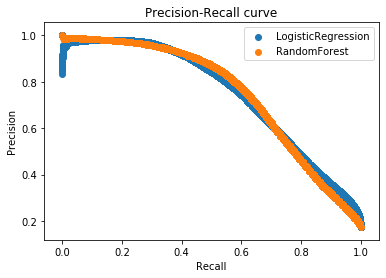

In [27]:
from sklearn.metrics import roc_curve, precision_recall_curve

precision_log, recall_log, _ = precision_recall_curve(y_test, prob_log[:, 1])
precision_rf, recall_rf, _ = precision_recall_curve(y_test, prob_rf[:, 1])

plt.scatter(recall_log, precision_log, label='LogisticRegression')
plt.scatter(recall_rf, precision_rf, label='RandomForest')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall curve')
plt.legend()
;

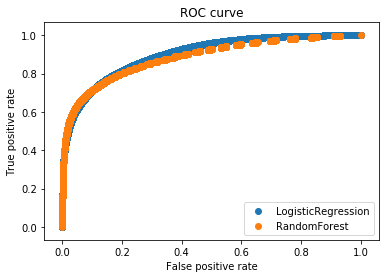

In [33]:
fpr_log, tpr_log, _ = roc_curve(y_test, prob_log[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, prob_rf[:, 1])


plt.scatter(fpr_log, tpr_log, label='LogisticRegression')
plt.scatter(fpr_rf, tpr_rf, label='RandomForest')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()

Найдём площади под кривыми roc-auc и precision-recall

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, prob_log[:, 1]), roc_auc_score(y_test, prob_rf[:, 1])

(0.8997772507984101, 0.8844446918968625)

In [35]:
from sklearn.metrics import auc

auc(recall_log, precision_log), auc(recall_rf, precision_rf)

(0.7496691827725739, 0.7483995035859707)

Найдём максимальную точность при полноте не менее 0.75

In [31]:
precision_log[recall_log >= 0.75].max()

0.5494976779452184

In [32]:
precision_rf[recall_rf >= 0.75].max()

0.5385794405545685

В дальнейшем для экспериментов будем использовать логистическую регрессию с наилучшими параметрами.

А теперь вернемся к исходной задаче. На данном этапе решения можно прийти к выводу, что предложенное кодирование текста может быть не самым удачным из-за большой матрицы объект-признак. Это ведет к ситуации, что не всякий алгоритм может быть применен в данной задаче по причине слишком большого признакового пространства, а кроме того, даже быстрые алгоритмы при наличии кросс-валидации могут начать работать медленно. Также в данных может быть шум, так как в качестве словаря были взяты все слова, даже те, которые встречались в одном-двух отзывах (например, опечатки). Поэтому кажется что неплохо было бы сократить размерность данных и по возможности избавиться от шума.

## Отбор признаков и уменьшение размерности

### По частоте
Попробуем сформировать выборку, в которой будут находиться только самые "важные" признаки, то есть в данном случае слова. Например, это можно сделать оставив топ слов по частоте (не считая стоп-слов вроде "a", "the", "it", ...). Кажется, что вхождение наиболее частых слов в отзыве, например, *good*, *bad* и т.д. являются вполне неплохими показателями.

### С помощью машинного обучения
Другой подход — воспользоваться имеющимися методами машинного обучения, а именно обученным на всех признаках случайным лесом. С помощью сдучайного леса есть возможность оценивать важность признаков. То есть можно выбрать топ слов, важных как признаки для задачи классификации. 

### Hashing trick
Какие еще могут быть способы работы с такого рода данными? По факту слова в текстах — это некоторое очень разреженное представление (как мы убедились выше). Подходом, отличным от двух вышеперечисленных, является [хэширование](https://en.wikipedia.org/wiki/Feature_hashing) или hashing trick: каждому слову сопоставляется некоторый хэш, после чего делается, например, bag-of-words. Плюсом этого способа является возможность обрабатывать не встречавшиеся ранее слова. Этот подход реализован в классе [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html). Кроме того, если выставить параметр *non_negative=True*, то можно интерпретировать полученные значения как некоторые "частоты".

Заметьте, что два последних подхода можно применять не обязательно к текстовым данным.

### Задание 

**(2 балла)**

Сформируйте три новые выборки, где каждый объект будет иметь 15000 признаков, следующим образом:
 - топ самых частотных слов
 - топ наиболее "важных" слов с помощью случайного леса
 - с помощью хэширования
 
Для последних двух выборок не забывайте фильтровать стоп-слова, для этого можно использовать параметр stop_words='english' у классов CountVectorizer, HashingVectorizer.

На четырех выборках (*bag-of-words* и трех новых) постройте *roc*-кривые, вычислив площадь под ними.

Что вы можете сказать о качестве этих подходов к сокращению размерности?
Выведите топ-20 самых важных слов от случайного леса и сравните их с топ-20 наиболее частотных. Много ли общих слов?

### Полная выборка bag of words

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_all = CountVectorizer()
X_train_all = vectorizer_all.fit_transform(list(X_train['title']))
X_test_all = vectorizer_all.transform(X_test['title'])
y_train_all = y_train
y_test_all = y_test
X_train_all

<825281x128223 sparse matrix of type '<class 'numpy.int64'>'
	with 7561131 stored elements in Compressed Sparse Row format>

### Поиск наилучших параметров логистической регрессии на всей выборке

In [10]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

param_distr = {
    'C': loguniform(1e-1, 1e2),
    'max_iter': loguniform(1e3, 1e4),
}
budget = 10

clf = LogisticRegression()

rand_log = RandomizedSearchCV(clf, param_distr, cv=3, n_jobs=-1, scoring='roc_auc', n_iter=budget, verbose=10)
rand_log.fit(X_train_all, y_train_all)
;

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  6.3min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  8.5min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  8.7min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  9.5min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 10.4min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.5min finished


''

In [11]:
rand_log.best_score_, rand_log.best_estimator_

(0.9582908038631924,
 LogisticRegression(C=2.4851185977212116, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=5846.765863443844, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False))

Рассчеты идут долго, поэтому гиперпараметры одного из результатов.
И в дальнейшем будем ориентироваться на них:

In [21]:
best_C = 2.485
best_max_iter = 5647

### Топ частотных слов


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_freq = CountVectorizer(stop_words='english', max_features=15000)
X_train_top = vectorizer_freq.fit_transform(list(X_train['title']))
X_test_top = vectorizer_freq.transform(X_test['title'])
y_train_top = y_train.copy()
y_test_top = y_test.copy()
X_train_top

<825281x15000 sparse matrix of type '<class 'numpy.int64'>'
	with 4712925 stored elements in Compressed Sparse Row format>

### Топ важных слов
Обучение даже без учета стоп слов занимает очень много времени. Вычисления произведём на кластере, результат запишем в файл.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

n = len(X_train)
# Для обучения локально использовалось меньше количество объектов
# n = 50000

vectorizer_imp = CountVectorizer(stop_words='english')
X_train_tmp = vectorizer_imp.fit_transform(list(X_train['title'][:n]))
X_test_tmp = vectorizer_imp.transform(X_test['title'])
y_train_imp = y_train[:n].copy()
y_test_imp = y_test.copy()
X_train_tmp

<825281x127929 sparse matrix of type '<class 'numpy.int64'>'
	with 4920051 stored elements in Compressed Sparse Row format>

In [145]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_features=best_params_tree['max_features'], criterion=best_params_tree['criterion'])
clf_rf.fit(X_train_tmp, y_train_imp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [17]:
# feature_importances = clf_rf.feature_importances_
feature_importances = np.array(pd.read_csv('feature_importances.csv'))[:, 1]
imp_ind = np.argsort(feature_importances)[::-1]

In [18]:
n = 15000
X_train_imp = X_train_tmp[:, imp_ind[:n]]
X_test_imp = X_test_tmp[:, imp_ind[:n]]
X_train_imp

<825281x15000 sparse matrix of type '<class 'numpy.int64'>'
	with 4685490 stored elements in Compressed Sparse Row format>

###  Хеширование

In [19]:
 from sklearn.feature_extraction.text import HashingVectorizer

vectorizer_hash = HashingVectorizer(stop_words='english', n_features=15000)
X_train_hash = vectorizer_hash.fit_transform(list(X_train['title']))
X_test_hash = vectorizer_hash.transform(X_test['title'])
y_train_hash = y_train.copy()
y_test_hash = y_test.copy()
X_train_hash

<825281x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 4919200 stored elements in Compressed Sparse Row format>

### ROC кривые

In [21]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(C=best_C, max_iter=best_max_iter)

clf_log.fit(X_train_all, y_train_all)
prob_all = clf_log.predict_proba(X_test_all)

clf_log.fit(X_train_top, y_train_top)
prob_top = clf_log.predict_proba(X_test_top)

clf_log.fit(X_train_imp, y_train_imp)
prob_imp = clf_log.predict_proba(X_test_imp)

clf_log.fit(X_train_hash, y_train_hash)
prob_hash = clf_log.predict_proba(X_test_hash)

All score 0.9603631356430176
Top score 0.9578579919580079
Important score 0.9587031944056211
Hash score 0.9471014677508536


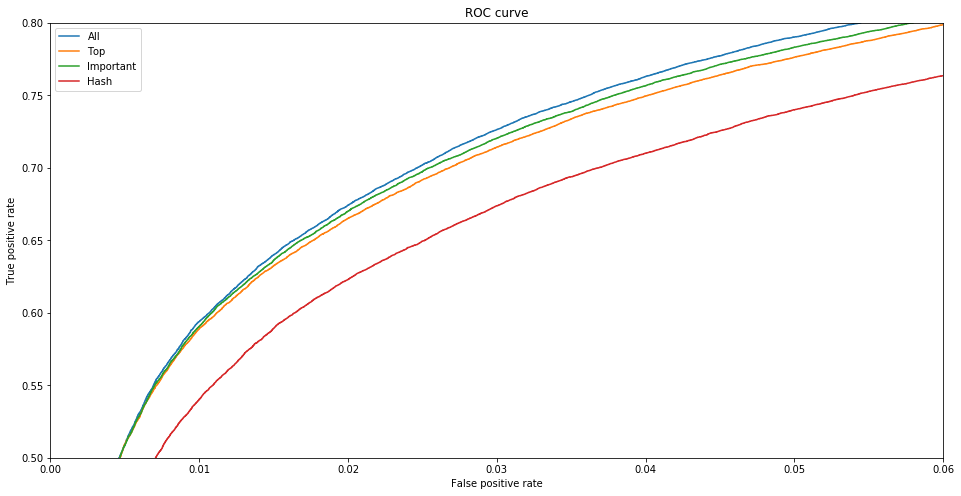

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(16, 8))

for (prob, test, label) in [
    (prob_all, y_test_all, 'All'),
    (prob_top, y_test_top, 'Top'),
    (prob_imp, y_test_imp, 'Important'),
    (prob_hash, y_test_hash, 'Hash'),
]:
    fpr, tpr, _ = roc_curve(test, prob[:, 1])
    plt.plot(fpr, tpr, label=label)
    score = roc_auc_score(test, prob[:, 1])
    print(label, 'score', score)

plt.xlim(0, 0.06)
plt.ylim(0.5, 0.8)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

### Сравнение качества
Конкуренция за первое место по сокращенным  признакам между частотой и важностью.
Важность побеждает благодаря тому, что позволяет отделять классы друг от друга, а частоста - это просто количество повторений, никак не связанных с классификацией

In [24]:
np.array(vectorizer_imp.get_feature_names())[imp_ind][:20]

array(['python', 'pandas', 'django', 'list', 'javascript', 'dataframe',
       'react', 'android', 'java', 'data', 'using', 'numpy', 'dictionary',
       'angular', 'file', 'php', 'flask', 'matplotlib', 'tkinter',
       'laravel'], dtype='<U88')

In [25]:
vectorizer_freq_20 = CountVectorizer(stop_words='english', max_features=20)
X_train_freq_20 = vectorizer_freq_20.fit_transform(list(X_train['title']))
sum_words = X_train_freq_20.sum(axis=0) 
words_freq = [[word, sum_words[0, idx]] for word, idx in     vectorizer_freq_20.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq = np.array(words_freq)

In [26]:
words_freq[:, 0]

array(['using', 'error', 'data', 'python', 'file', 'function', 'value',
       'use', 'array', 'multiple', 'object', 'list', 'react', 'does',
       'values', 'code', 'android', 'string', 'class', 'column'],
      dtype='<U8')

Глядя на пересечение top20 видим, что есть похожие слова, но совсем не в том порядке важности

Но даже 15000 признаков — это достаточно много. Допустим, мы хотим уменьшить размерность до 2000 признаков, однако можно заметить, что даже три предыдущие способа давали небольшое ухудшение в качестве. 

### PCA

Одним из способов сокращения размерности является метод главных компонент ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)). Это преобразование позволяет получить вес каждого признака в компоненте. Например, если применить его к bag-of-words, можно найти наиболее важные слова, влияющие на данную компоненту. Для работы с большими разреженными матрицами в sklearn рекомендуется использовать [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

### Задание

**(1.5 балла)**

Попробуйте сократить размерность до 2000 двумя способами:
* наилучшим из трех предыдущих
- для выборки со всеми признаками обучите *PCA*-преобразование 

Постройте новый график качества. Какой из двух подходов работает лучше?
Для первых трех компонент преобразования найдите топ-30 наиболее важных слов. Можете ли вы охарактеризовать как-то каждую из этих групп?

### Сократим выборку для быстроты рсчетов

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# сокритм выборку, для скорости обучения
n = 50000

vectorizer_all = CountVectorizer()
X_train_vec_50 = vectorizer_all.fit_transform(list(X_train['title'][:n]))
X_test_vec_50 = vectorizer_all.transform(X_test['title'])
y_train_vec_50 = y_train[:n]
y_test_vec_50 = y_test
X_train_vec_50

<50000x24477 sparse matrix of type '<class 'numpy.int64'>'
	with 459235 stored elements in Compressed Sparse Row format>

Обучим PCA преобразование 

In [14]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2000, random_state=random_state)
X_train_svd = svd.fit_transform(X_train_vec_50)
X_test_svd = svd.transform(X_test_vec_50)
y_train_svd = y_train_vec_50

Выберем наиболее важные фичи нашей выборки 

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_features=best_params_tree['max_features'], criterion=best_params_tree['criterion'])
clf_rf.fit(X_train_vec_50, y_train_vec_50)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
feature_importances = clf_rf.feature_importances_
n = 2000
ind_initial = np.argsort(feature_importances)[::-1]
ind = ind_initial
X_train_imp_short = X_train_vec_50[:, ind]
X_test_imp_short = X_test_vec_50[:, ind]
y_train_imp_short = y_train_vec_50
X_train_imp_short

<50000x24477 sparse matrix of type '<class 'numpy.int64'>'
	with 459235 stored elements in Compressed Sparse Row format>

Проверим наши классификаторы на тестовых данных

In [22]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(C=best_C, max_iter=best_max_iter)

clf_log.fit(X_train_imp_short, y_train_imp_short)
prob_imp_short = clf_log.predict_proba(X_test_imp_short)

clf_log.fit(X_train_svd, y_train_svd)
prob_svd = clf_log.predict_proba(X_test_svd)


Important score 0.9341127423504721
SVD score 0.9236037090037799


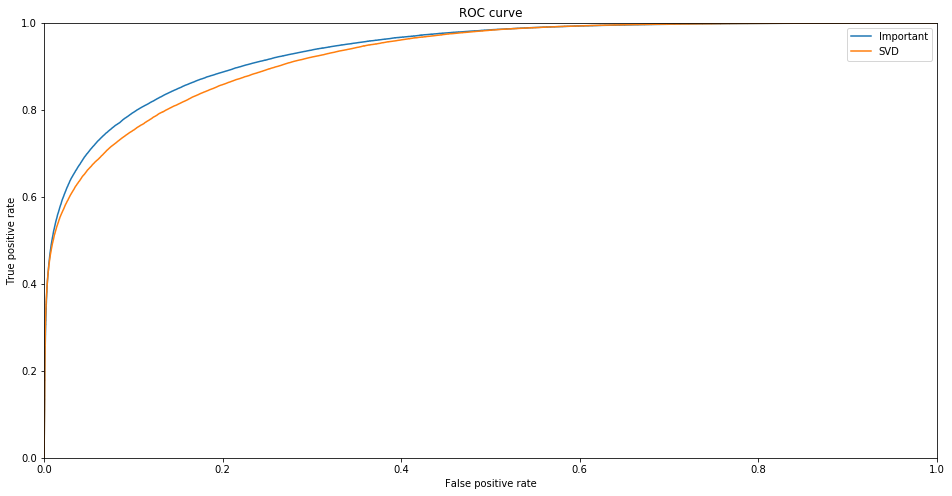

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(16, 8))

for (prob, test, label) in [
    (prob_imp_short, y_test, 'Important'),
    (prob_svd, y_test, 'SVD'),
]:
    fpr, tpr, _ = roc_curve(test, prob[:, 1])
    plt.plot(fpr, tpr, label=label)
    score = roc_auc_score(test, prob[:, 1])
    print(label, 'score', score)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

Метод важности фич показывает лучший результат, однако по времени работы превосходит PCA метод.

Найдем топ 30 слов для первых трёх компонент.

In [57]:
first = pd.DataFrame(svd.components_, columns=vectorizer_all.get_feature_names()).T.nlargest(30, 0).index
first = np.array(first)
first

array(['to', 'how', 'in', 'the', 'of', 'and', 'with', 'from', 'is',
       'using', 'on', 'for', 'an', 'not', 'data', 'can', 'get', 'when',
       'file', 'python', 'it', 'value', 'function', 'use', 'do', 'error',
       'array', 'my', 'that', 'list'], dtype=object)

In [ ]:
second = pd.DataFrame(svd.components_, columns=vectorizer_all.get_feature_names()).T.nlargest(30, 1).index
second = np.array(second)
second

In [ ]:
third = pd.DataFrame(svd.components_, columns=vectorizer_all.get_feature_names()).T.nlargest(30, 2).index
third = np.array(third)
third

Для каждой компоненты выделим уникальные слова

In [ ]:
from functools import reduce
diff1 = reduce(np.setdiff1d, (first, second, third))
diff1

In [ ]:
diff2 = reduce(np.setdiff1d, (second, first, third))
diff2

In [ ]:
diff3 = reduce(np.setdiff1d, (third, second, first))
diff3

Сложно придумать чем особенным объединяются уникальные слова в каждой группе, но попробуем предположить.
Первая группа говорит собственно о вопросе автора. Как использовать, делать.
Вторая и третья группа используют ключевые слова в различных тематиках

In [58]:
Ура! Полученных знаний достаточно, что бы сформировать [базовое решение](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/yzgiefbroke1ywy/baseline.ipynb) для [конкурса](https://www.kaggle.com/c/competition-3-yandex-shad-spring-2020/leaderboard) достаточно только перейти от бинарной классификации к многоклассовой. Теперь попробуй самостоятельно улучшить базовое решение =)

array(['in', 'the', 'of', 'not', 'is', 'and', 'for', 'can', 'python',
       'why', 'error', 'value', 'with', 'what', 'does', 'column',
       'working', 'when', 'function', 'same', 'but', 'values', 'an',
       'list', 'react', 'array', 'data', 'using', 'loop', 'are'],
      dtype=object)

In [59]:
third = pd.DataFrame(svd.components_, columns=vectorizer_all.get_feature_names()).T.nlargest(30, 2).index
third = np.array(third)
third

array(['the', 'of', 'is', 'and', 'on', 'not', 'when', 'what', 'it', 'why',
       'from', 'for', 'same', 'that', 'value', 'get', 'with', 'can',
       'does', 'there', 'my', 'way', 'an', 'if', 'number', 'at', 'list',
       'function', 'object', 'code'], dtype=object)

Для каждой компоненты выделим уникальные слова

In [71]:
from functools import reduce
diff1 = reduce(np.setdiff1d, (first, second, third))
diff1

array(['do', 'file', 'how', 'to', 'use'], dtype=object)

In [72]:
diff2 = reduce(np.setdiff1d, (second, first, third))
diff2

array(['are', 'but', 'column', 'loop', 'react', 'values', 'working'],
      dtype=object)

In [74]:
diff3 = reduce(np.setdiff1d, (third, second, first))
diff3

array(['at', 'code', 'if', 'number', 'object', 'there', 'way'],
      dtype=object)

Сложно придумать чем особенным объединяются уникальные слова в каждой группе, но попробуем предположить.
Первая группа говорит собственно о вопросе автора. Как использовать, делать.
Вторая и третья группа используют ключевые слова в различных тематиках

Ура! Полученных знаний достаточно, что бы сформировать [базовое решение](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/yzgiefbroke1ywy/baseline.ipynb) для [конкурса](https://www.kaggle.com/c/competition-3-yandex-shad-spring-2020/leaderboard) достаточно только перейти от бинарной классификации к многоклассовой. Теперь попробуй самостоятельно улучшить базовое решение =)

### Какие еще могут быть способы обработки текстовых данных?

Как можно заметить, подход с мешком слов, в котором учитывается лишь факт вхождения слова в отзыв, весьма наивен, так как не позволяет учесть информацию в скольки отзывах встречалось данное слово (например, чтобы избавиться от очень редких слов). В этом случае может помочь [tf-idf кодирование](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

Другой недостаток описанного в задании подхода заключается в использовании абсолютных частот слов. У некоторых слов они могут быть очень большими, в то же время у других — низкими. Чтобы "сгладить" разницу между ними, можно сделать логарифмирование, т.е. применить преобразование $x \to log(x + 1)$ (так как при bag-of-words кодировании могут встречаться 0).

Неплохое руководство можно найти в разделе [извлечения признаков](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) из документации sklearn.